In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

from scipy.stats import norm, multivariate_normal
from scipy.interpolate import griddata

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
class LinearMap(nn.Module):
    
    def __init__(self, d):
        super(LinearMap, self).__init__()
        self.linear = nn.Linear(d, 1)
        for param in self.linear.parameters():
            param.requires_grad = False
        nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, x):
        return self.linear(x)[:, 0]

In [4]:
def phi(x, σ):
    return σ * σ * h(x)

In [5]:
def sample_gaussian(μ, σ, N, d):
    X = torch.normal(μ * torch.ones(N, d), σ * torch.ones(N, d))
    return X

In [6]:
def dm(x, h, ϕ_prev, ϵ=0.01, L=1000):
    
    x1_idx, x2_idx = torch.meshgrid(torch.arange(len(x)), torch.arange(len(x)), indexing='ij')
    x1, x2 = x[x1_idx], x[x2_idx]
    g = torch.exp(-torch.square(x1 - x2).sum(-1)/(4*ϵ))

    g_rowsum = torch.sum(g, dim=1)
    g_1, g_2 = torch.meshgrid(g_rowsum, g_rowsum, indexing='ij')
    k = g/(torch.sqrt(g_1)*torch.sqrt(g_2))

    d = torch.sum(k, axis=1)
    T = k/d[:, None]
    π = d/d.sum()

    hx_hat = torch.sum(π*h(x))

    ϕ = ϕ_prev

    for t in tqdm(range(1, L+1)):
        ϕ = (T * ϕ).sum(axis=1) + ϵ*(h(x) - hx_hat)
    
    return ϕ

In [7]:
def pointcloud_to_grid_data(X, ϕ, bounds=[[-5, 5], [-5, 5]], N=200):

    # Create Mask
    bounds = np.asarray(bounds)
    for j in range(bounds.shape[0]):
        if j == 0:
            mask = (X[:, j]>bounds[j, 0]) & (X[:, j]<bounds[j, 1])
        else:
            mask = mask & (X[:, j]>bounds[j, 0]) & (X[:, j]<bounds[j, 1])

    # Select points with mask
    X_sel = X[mask]
    ϕ_sel = ϕ[mask]

    # Convert tensor to numpy array
    if isinstance(X, torch.Tensor):
        X_sel = X_sel.cpu().numpy()
    if isinstance(X, torch.Tensor):
        ϕ_sel = ϕ_sel.cpu().numpy()
    
    # Sample point cloud data (replace this with your actual data)
    # Assuming point cloud data is in the form of a 2D numpy array with columns [x, y, value]
    point_cloud_data = np.concatenate([X_sel, ϕ_sel[:, None]], axis=1)
    
    # Extract x, y, and values
    x = point_cloud_data[:, 0]
    y = point_cloud_data[:, 1]
    values = point_cloud_data[:, 2]
    
    # Define the grid over which you want to interpolate
    x_resample = np.linspace(min(x), max(x), N)
    y_resample = np.linspace(min(y), max(y), N)
    grid_x, grid_y = np.meshgrid(x_resample, 
                                 y_resample, 
                                 indexing='xy')
    
    # Perform interpolation
    start_idx = int(0.05 * N)
    end_idx = int(0.95 * N)
    grid_values = griddata((x, y), values, (grid_x, grid_y), method='linear')
    grid_values = grid_values[start_idx:end_idx, start_idx:end_idx]
    x_resample = x_resample[start_idx:end_idx]
    y_resample = y_resample[start_idx:end_idx]
    
    grid_x, grid_y = np.meshgrid(x_resample, 
                                 y_resample, 
                                 indexing='xy')
    
    ϕx = grid_values


    fig, ax = plt.subplots(1, 3, figsize=(16, 4))

    # Generate grid and h(x) values
    grid = torch.from_numpy(np.concatenate([grid_x.flatten()[:, None], grid_y.flatten()[:, None]], axis=1)).float().to(device)
    hx = h(grid).reshape(grid_x.shape).cpu().numpy()
    im = ax[0].imshow(hx, extent=(min(x_resample), max(x_resample),
                          min(y_resample), max(y_resample)), origin='lower')
    ax[0].set_xlabel('$x_1$')
    ax[0].set_ylabel('$x_2$')
    ax[0].set_title('$h(x)$')
    fig.colorbar(im, orientation='vertical')
    

    # Compute and plot px
    grid = np.concatenate([grid_x.flatten()[:, None], grid_y.flatten()[:, None]], axis=1)
    dist = multivariate_normal(np.ones(d)*μ, np.identity(d)*σ**2)
    px = dist.pdf(grid).reshape(grid_x.shape)
    
    im = ax[1].imshow(px, extent=(min(x_resample), max(x_resample),
                          min(y_resample), max(y_resample)), origin='lower')
    ax[1].set_xlabel('$x_1$')
    ax[1].set_ylabel('$x_2$')
    ax[1].set_title('$p(x)$')
    
    fig.colorbar(im, orientation='vertical')
    
    # Plot Target values
    im = ax[2].imshow(ϕx, extent=(min(x_resample), max(x_resample),
                          min(y_resample), max(y_resample)), origin='lower')
    ax[2].set_xlabel('$x_1$')
    ax[2].set_ylabel('$x_2$')
    ax[2].set_title('$\phi(x)$')
    fig.colorbar(im, orientation='vertical')

    grid = np.concatenate([grid_x[..., None], grid_y[..., None]], axis=-1)
    
    return grid, hx, px, ϕx        

In [8]:
def create_data_tensors(X, ϕ_dm, bounds, window=(32, 32), N=400):

    grid, hx, px, ϕx = pointcloud_to_grid_data(X, ϕ_dm, bounds=bounds)
    
    grid_x = torch.from_numpy(grid).to(device)
    grid_h = torch.from_numpy(hx).to(device)[...,None]
    grid_p = torch.from_numpy(px).to(device)[...,None]
    grid_ϕ = torch.from_numpy(ϕx).to(device)[...,None]
    
    M, N, D = grid_x.shape
    w_i, w_j = window
    
    tensor_data_a = []
    tensor_data_u = []
    
    grid_a = torch.concat([grid_x, grid_h, grid_p], dim=-1)
    grid_a = torch.permute(grid_a, dims=(2, 0, 1))
    grid_u = torch.permute(grid_ϕ, dims=(2, 0, 1))
    
    for i in range(0, M-w_i+1, w_i//2):
        for j in range(0, N-w_j+1, w_j//2):
            tensor_data_a.append(grid_a[:, i:i+w_i, j:j+w_j])
            tensor_data_u.append(grid_u[:, i:i+w_i, j:j+w_j])
    
    ax_tensor = torch.stack(tensor_data_a)
    ux_tensor = torch.stack(tensor_data_u)
    
    return ax_tensor, ux_tensor
    

In [9]:
def plot_functions(X, μ, σ):

    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    
    _ = ax[0].hist2d(X[:, 0].cpu(), X[:, 1].cpu(), bins=60)
    ax[0].set_title(f'Samples from N({μ:.2f}, {σ:.2f})')
    ax[0].set_xlabel('$x_1$')
    ax[0].set_ylabel('$x_2$')
    
    
    im = ax[1].scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=h(X).cpu())
    ax[1].set_title('$h(\mathbf{x}$)')
    ax[1].set_xlabel('$x_1$')
    ax[1].set_ylabel('$x_2$')
    plt.colorbar(im)
    
    im2 = ax[2].scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=phi(X, σ).cpu(), marker='o', label='AnalyticSoln')
    ax[2].set_xlabel('X1')
    ax[2].set_ylabel('X2')
    ax[2].set_title('$\phi(\mathbf{x})$')
    plt.colorbar(im2)

    return fig

In [10]:
N = 20000
L = 10000
d = 2

N_dist = 15
μ_list = np.random.uniform(-20, 20, N_dist)
σ_list = np.random.uniform(2, 5, N_dist)

In [11]:
import os

In [12]:
# torch.save(h.state_dict(), 'data/h.pt')

100%|██████████| 10000/10000 [01:09<00:00, 143.47it/s]


mu: 18.86 sigma: 2.42 N: 20000 L:10000 Error: -29.9888


100%|██████████| 10000/10000 [01:09<00:00, 143.62it/s]


mu: -10.97 sigma: 4.97 N: 20000 L:10000 Error: -21.2523


100%|██████████| 10000/10000 [01:09<00:00, 143.62it/s]


mu: 17.41 sigma: 3.48 N: 20000 L:10000 Error: -29.8334


100%|██████████| 10000/10000 [01:09<00:00, 143.60it/s]


mu: -15.97 sigma: 3.30 N: 20000 L:10000 Error: -9.5102


100%|██████████| 10000/10000 [01:09<00:00, 143.62it/s]


mu: 18.74 sigma: 4.07 N: 20000 L:10000 Error: -10.7888


100%|██████████| 10000/10000 [01:09<00:00, 143.63it/s]


mu: 1.44 sigma: 2.15 N: 20000 L:10000 Error: -41.9608


100%|██████████| 10000/10000 [01:09<00:00, 143.63it/s]


mu: -7.62 sigma: 2.88 N: 20000 L:10000 Error: -7.9396


100%|██████████| 10000/10000 [01:09<00:00, 143.61it/s]


mu: -3.52 sigma: 4.72 N: 20000 L:10000 Error: -9.1846


100%|██████████| 10000/10000 [01:09<00:00, 143.61it/s]


mu: 10.46 sigma: 2.59 N: 20000 L:10000 Error: -37.6709


100%|██████████| 10000/10000 [01:09<00:00, 143.61it/s]


mu: 8.79 sigma: 2.66 N: 20000 L:10000 Error: -37.0417


100%|██████████| 10000/10000 [01:09<00:00, 143.61it/s]


mu: 0.13 sigma: 2.14 N: 20000 L:10000 Error: 0.6559


100%|██████████| 10000/10000 [01:09<00:00, 143.61it/s]


mu: 6.97 sigma: 4.41 N: 20000 L:10000 Error: -23.9180


100%|██████████| 10000/10000 [01:09<00:00, 143.63it/s]


mu: -16.58 sigma: 4.83 N: 20000 L:10000 Error: -9.9527


100%|██████████| 10000/10000 [01:09<00:00, 143.63it/s]


mu: 13.67 sigma: 3.74 N: 20000 L:10000 Error: -39.5249


100%|██████████| 10000/10000 [01:09<00:00, 143.63it/s]


mu: -1.73 sigma: 4.75 N: 20000 L:10000 Error: -11.4502


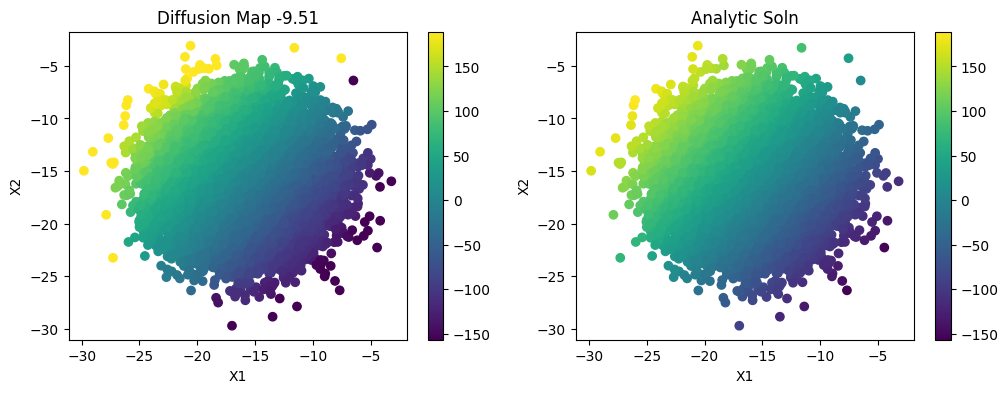

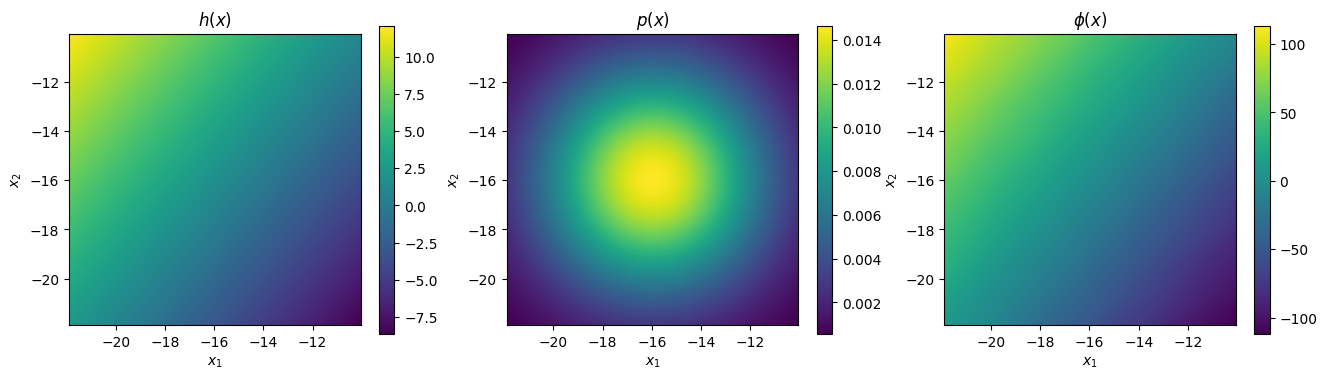

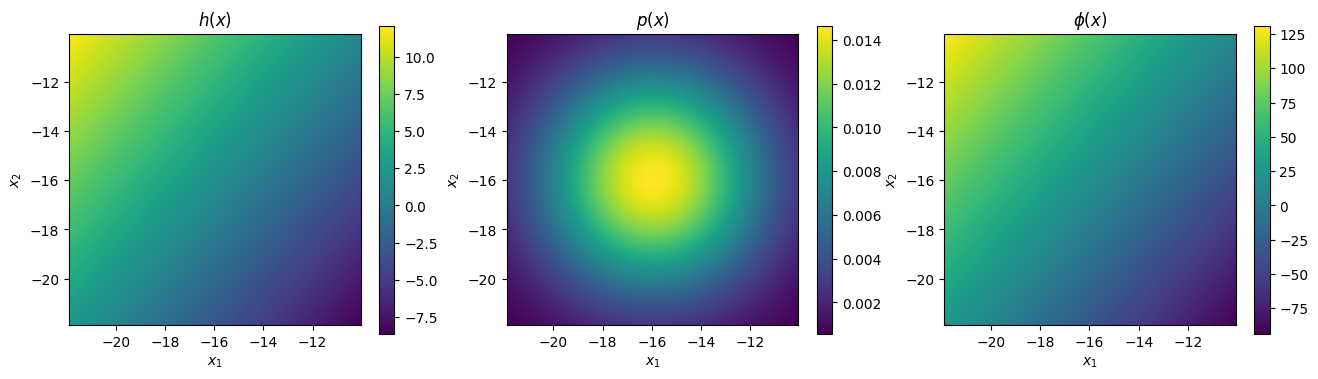

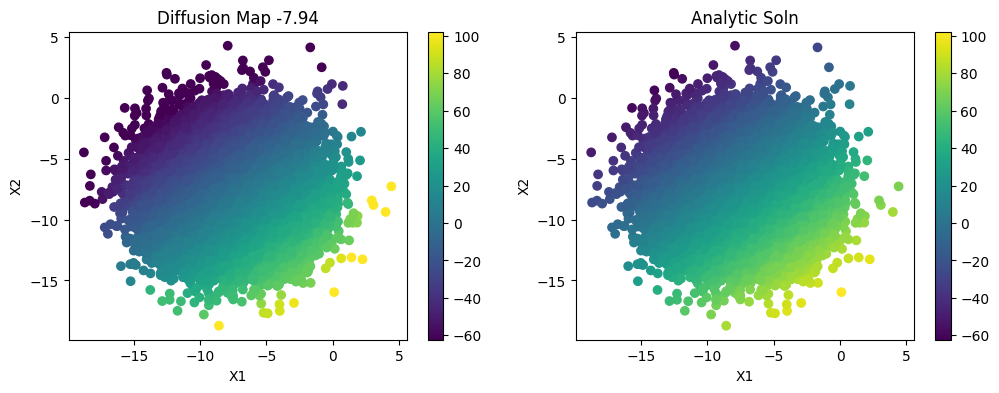

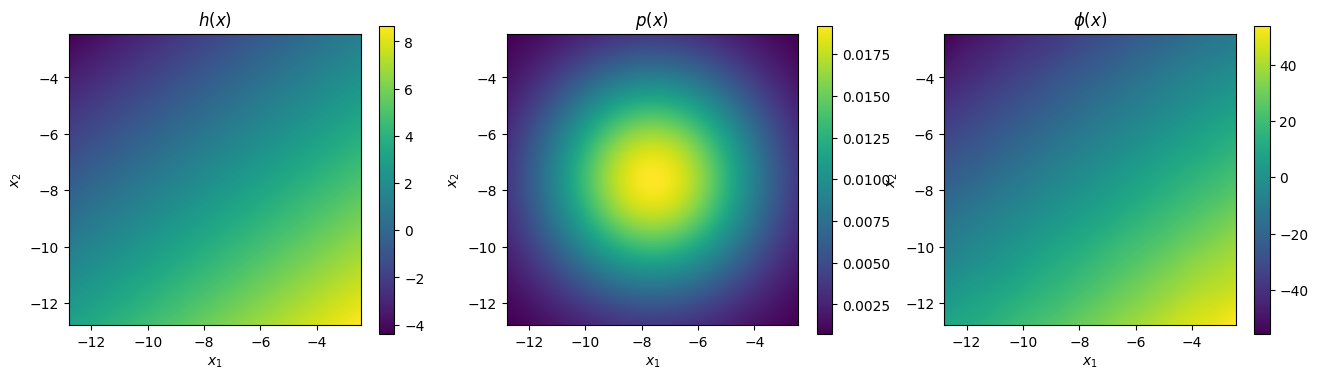

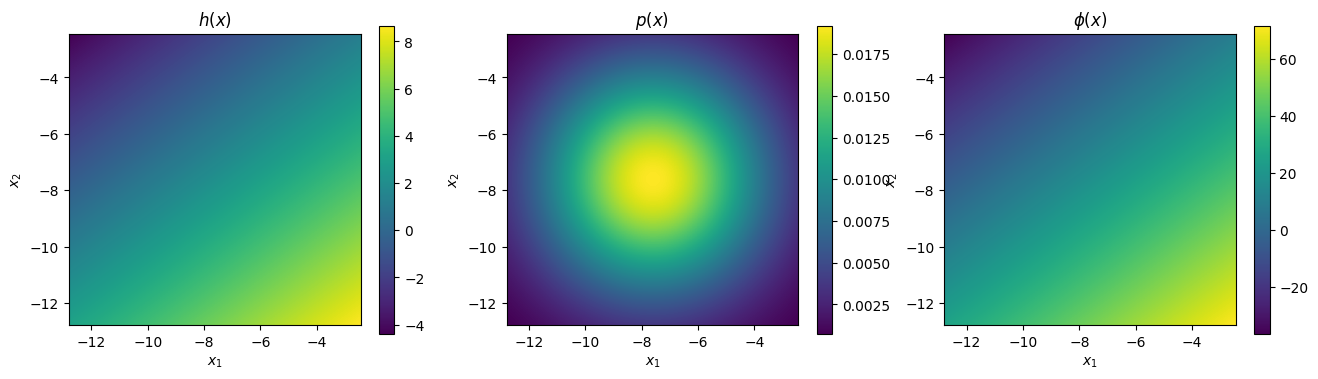

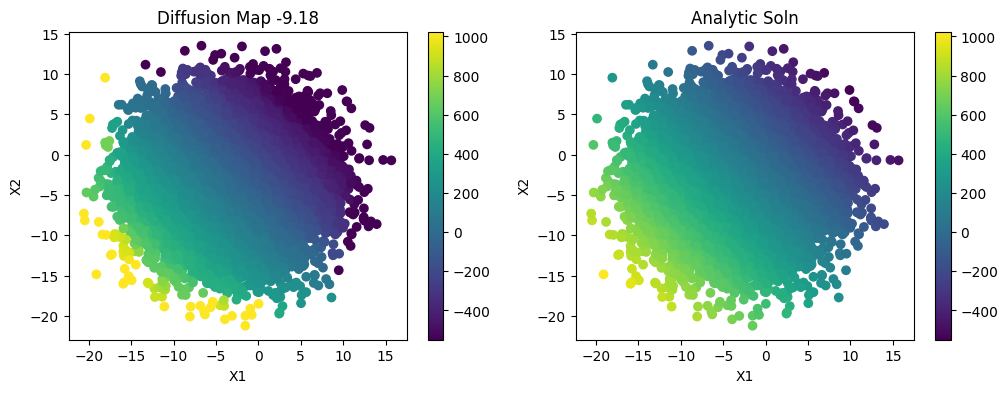

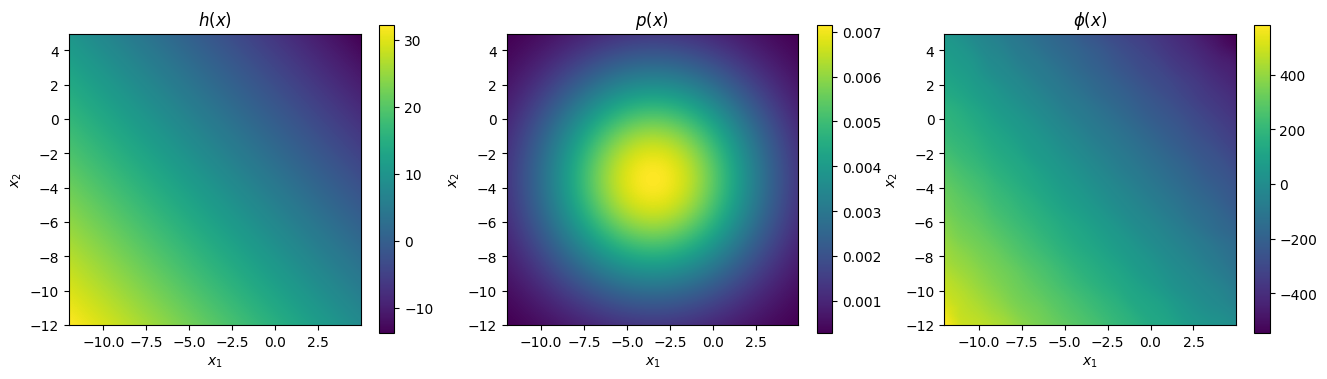

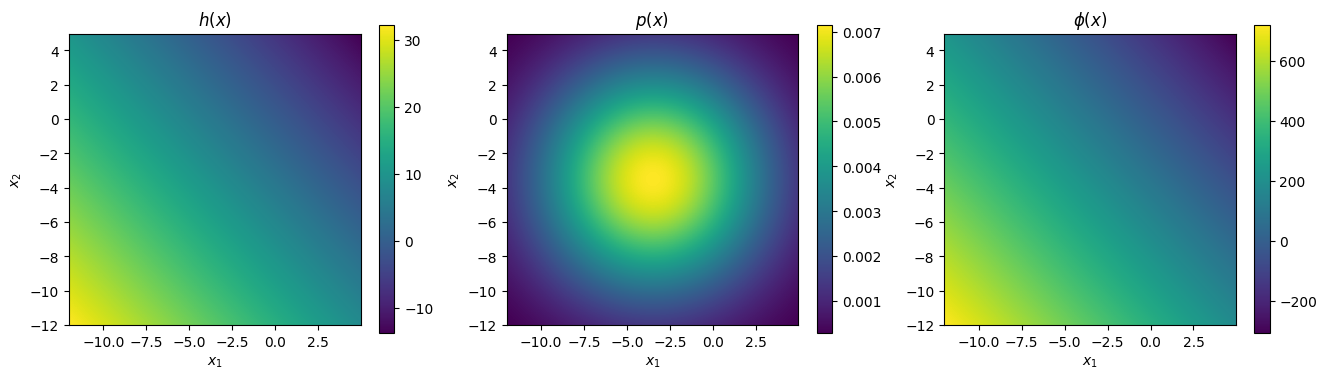

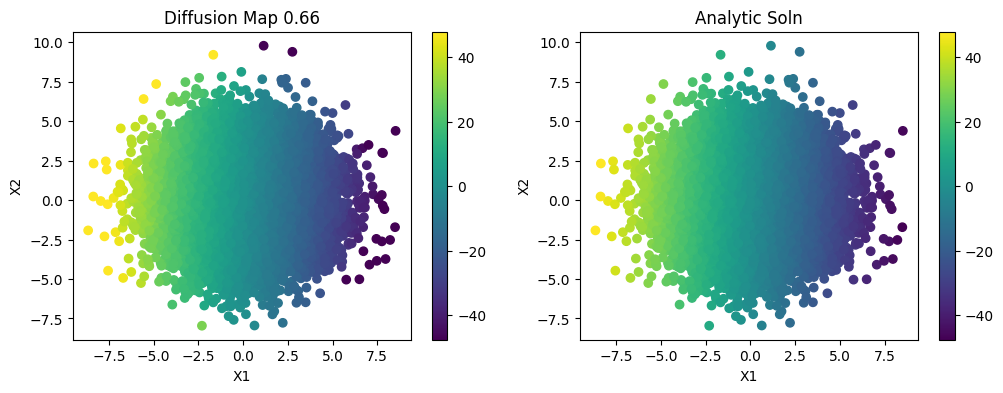

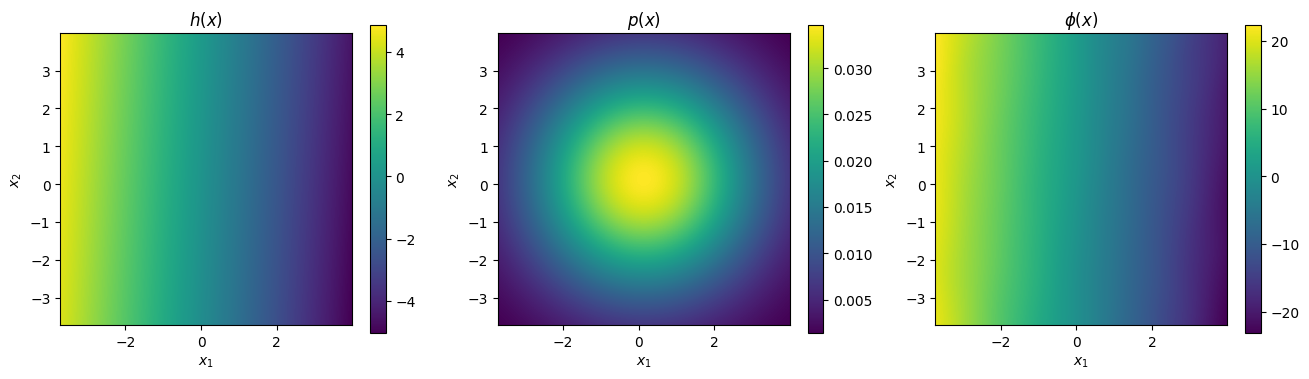

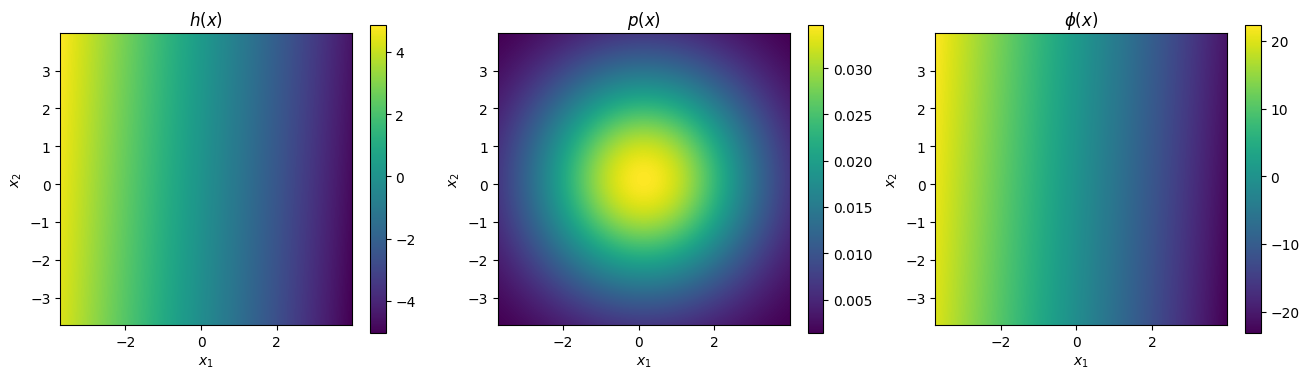

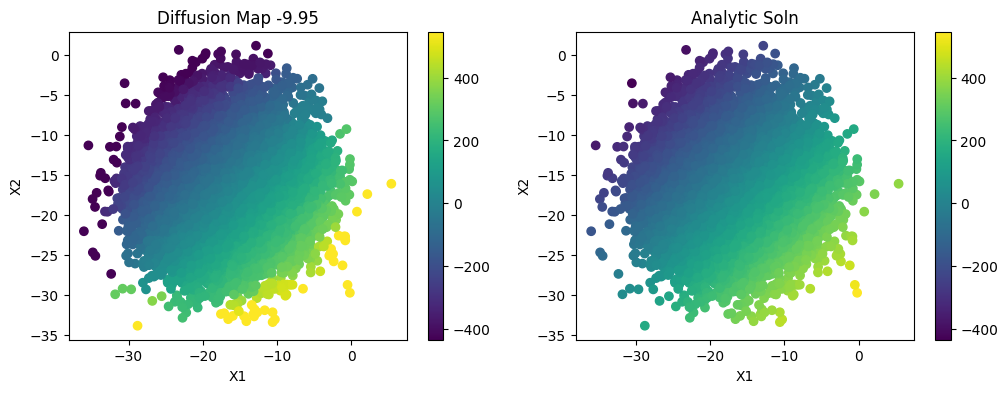

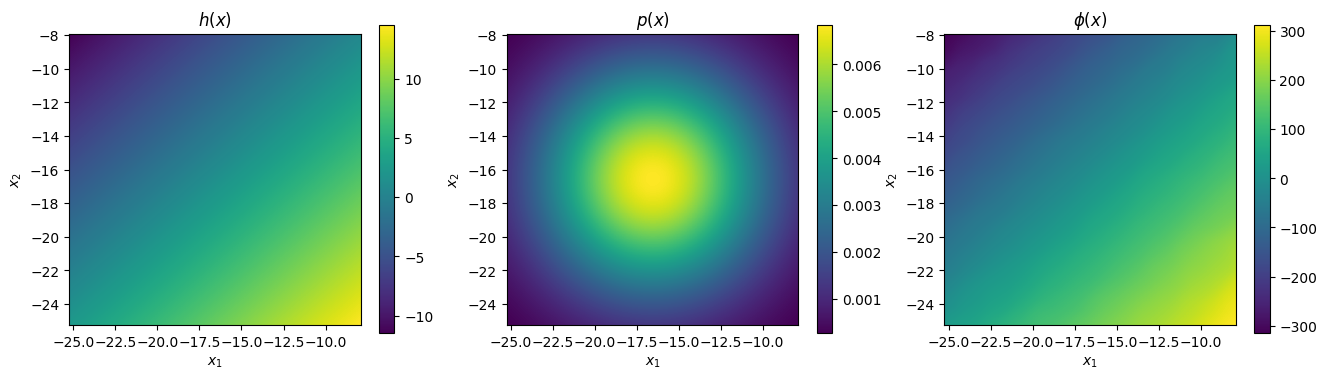

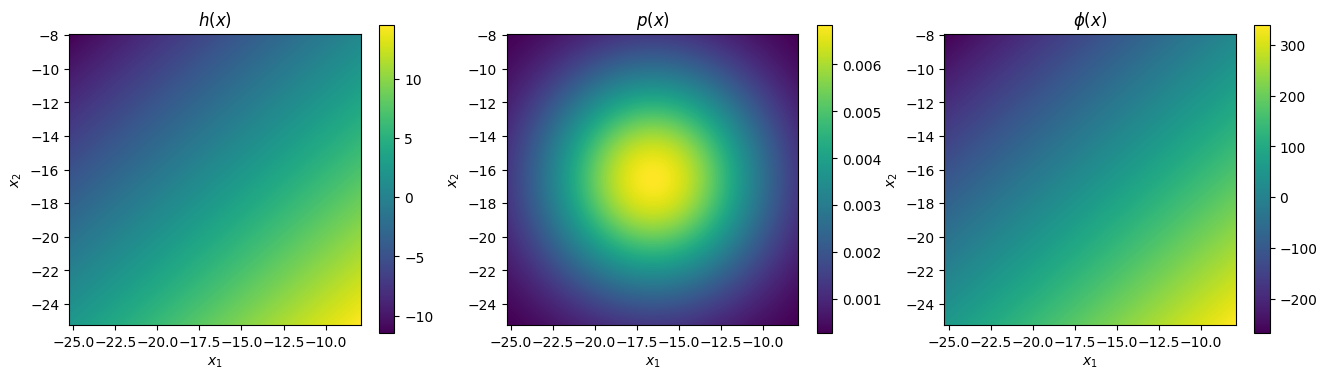

In [13]:
# ax_tensor_list = []
# ux_tensor_list = []


for i in range(len(μ_list)):

    μ = float(μ_list[i])
    σ = float(σ_list[i])

    
    # Genereate linear function for h(x)
    h = LinearMap(d)
    
    # Generate samples from density p(x)
    X = sample_gaussian(μ, σ, N, d)
    
    # Move Tensors to GPU if available
    X = X.to(device)
    h = h.to(device)
    
    # Plot functions
    # fig = plot_functions(X, μ_list[i], σ_list[i])

    dist = multivariate_normal(np.ones(d)*μ, np.identity(d)*σ**2)
    px = torch.from_numpy(dist.pdf(X.cpu().numpy())).to(device)


    # Run DiffusionMap approach
    ϕ_dm = dm(X, h, torch.randn(len(X)).to(device), L=L, ϵ=0.1)

    # Compute L1-loss with the analytic solution
    pred = ϕ_dm
    tar = phi(X, σ)
    error = 1 - torch.square(pred - tar).sum()/torch.square(tar - tar.mean()).sum()
    print(f"mu: {μ:.2f} sigma: {σ:.2f} N: {N} L:{L} Error: {error:.4f}")
    
    # Move Array to CPU
    X_cpu = X.cpu().numpy()
    # Compute Analytic Solution
    ϕ_analytic = phi(X, σ).cpu()

    if error > -10:
    
        # Plot Results
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        im1 = ax[0].scatter(X_cpu[:, 0], X_cpu[:, 1], 
                            c=np.clip(ϕ_dm.cpu().numpy(), a_min=ϕ_analytic.min(), a_max=ϕ_analytic.max()), 
                            marker='o', label='DiffusionMap')
        ax[0].set_xlabel('X1')
        ax[0].set_ylabel('X2')
        ax[0].set_title(f'Diffusion Map {error:.2f}')
        
        im2 = ax[1].scatter(X_cpu[:, 0], X_cpu[:, 1], c=ϕ_analytic, marker='o', label='AnalyticSoln')
        ax[1].set_xlabel('X1')
        ax[1].set_ylabel('X2')
        ax[1].set_title('Analytic Soln')
        
        fig.colorbar(im1, ax=ax[0])
        fig.colorbar(im2, ax=ax[1])
        
        savedir = f"data/{μ:.2f}_{σ:.2f}"
        if not os.path.exists(savedir):
            os.makedirs(savedir)

        fig.savefig(f"{savedir}/plot.png", bbox_inches='tight')
    
        
        bounds = np.array([[μ-2*σ, μ+2*σ],
                           [μ-2*σ, μ+2*σ]])
        
        ax_tensor, ux_dm_tensor = create_data_tensors(X, ϕ_dm, bounds)
        ax_tensor, ux_analytic_tensor = create_data_tensors(X, ϕ_analytic.to(device), bounds)
        
        torch.save(ax_tensor, f"{savedir}/ax.pt")
        torch.save(ux_dm_tensor, f"{savedir}/ux_dm.pt")
        torch.save(ux_analytic_tensor, f"{savedir}/ux_analytic.pt")


    del(X)
    del(ϕ_dm)